<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fastai3_lesson4_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
from fastai.tabular import *
from fastai.collab import *
import pandas as pd
import matplotlib.pyplot as plt

In [107]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [108]:
ls {path}

ratings.csv*


In [109]:
df = pd.read_csv(path/'ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [0]:
data_sample = CollabDataBunch.from_df(df, user_name='userId', item_name='movieId', rating_name='rating', seed=42)

In [0]:
learner_sample = collab_learner(data_sample, n_factors=50, y_range=[0,5.5])

In [112]:
learner_sample.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


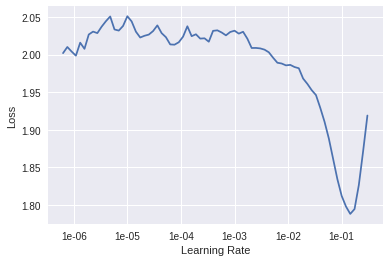

In [113]:
learner_sample.recorder.plot(skip_end=18)

In [114]:
"""
without y_range
epoch	train_loss	valid_loss
1	5.920862	1.484214
2	5.004538	8.521023
3	6.561814	4.836695
4	3.368830	1.466033
5	1.234028	1.108371

with y_range
epoch	train_loss	valid_loss
1	1.732687	1.291793
2	0.913472	0.728804
3	0.676444	0.728984
"""
from fastai.callbacks import SaveModelCallback
save_model = SaveModelCallback(learner_sample, name='v1')
learner_sample.fit_one_cycle(10, max_lr=2e-2, callbacks=[save_model])

epoch,train_loss,valid_loss
1,1.749584,1.352984
2,0.915365,0.716959
3,0.682466,0.767699
4,0.470093,0.803767
5,0.283130,0.771056
6,0.161176,0.784054
7,0.089248,0.782677
8,0.046488,0.795954
9,0.024660,0.796947
10,0.015728,0.798064


In [115]:
weird_return = learner_sample.load('v1')
type(weird_return)

fastai.collab.CollabLearner

In [116]:
type(learner_sample)

fastai.collab.CollabLearner

In [117]:
learner_sample.validate()

[0.7169588]

In [118]:
learner_sample.lr_find(1e-10, 1e-01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


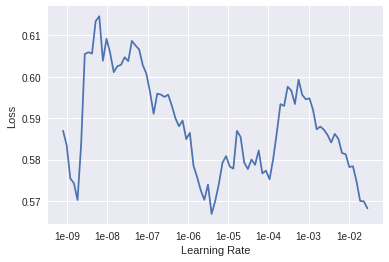

In [119]:
learner_sample.recorder.plot()

epoch,train_loss,valid_loss
1,0.584104,0.709611
2,0.574593,0.682045
3,0.546741,0.654887
4,0.511989,0.639569
5,0.487948,0.634521
6,0.470416,0.630616
7,0.443441,0.629381
8,0.432180,0.628374
9,0.421960,0.628232
10,0.417903,0.628160


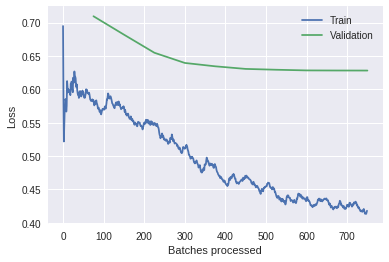

In [120]:
learner_sample.load('v1')
save_model = SaveModelCallback(learner_sample, name='v2')
learner_sample.fit_one_cycle(10, max_lr=1e-3, callbacks=[save_model])
learner_sample.recorder.plot_losses()

In [0]:
learner_sample.load('v2');

In [122]:
learner_sample.validate()

[0.6281604]

epoch,train_loss,valid_loss
1,3.798452,3.644138
2,2.154067,1.138628
3,1.083751,1.098889
4,0.738600,1.312123
5,1.008404,1.565848
6,1.130878,1.493636
7,1.034368,1.331754
8,0.781030,1.124204
9,0.566122,1.008733
10,0.368302,0.886550


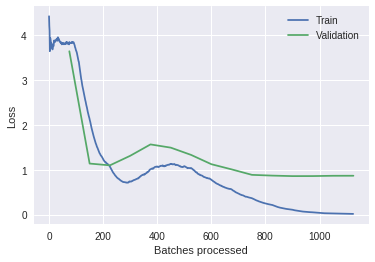

In [123]:
def diy(df):
  databunch = CollabDataBunch.from_df(df, user_name='userId', item_name='movieId', rating_name='rating', seed=42)
  import pdb
  from IPython.display import display
  # TODO: see if I can get to the indexes built by the CollabFilterDataset can be used just in case, otherwise I don't care - proper ones should be sent to the model
  #userEmbById = {itemId:embIdx for (embIdx, itemId) in enumerate(df['userId'].unique())}
  #movieEmbById = {itemId:embIdx for (embIdx, itemId) in enumerate(df['movieId'].unique())}
  n_users = len(df['userId'].unique())
  n_movies = len(df['movieId'].unique())
  n_dim = 50
  min_rating = 0
  max_rating = 5.5

  #batch = next(iter(databunch.train_ds))

  def embedding(n_items, embedding_dim=n_dim):
    e = nn.Embedding(num_embeddings=n_items+1, embedding_dim=embedding_dim)
    e.weight.data.uniform_(0.01)
    return e
  
  class EmbeddingDotBias(nn.Module):
    def __init__(self):
      super(EmbeddingDotBias, self).__init__()
      # TODO: this is pretty weird to add a 1 to make stuff work
      # dict transform sort of applied before getting here as max user_id is ~600 and max movie_id is ~50k
      self.user_embedding = embedding(n_users+1)
      self.movie_embedding = embedding(n_users+1)
      self.user_bias = embedding(n_users+1, 1)
      self.movie_bias = embedding(n_movies+1, 1)
      
    #(Pdb) batch[0]
    #CollabLine userId 73; movieId 1097; 
    #(Pdb) batch[1]
    # FloatItem 4.0
    def forward(self, movies_batch, users_batch):
      u = self.user_embedding(users_batch)
      m = self.movie_embedding(movies_batch)
      u_b = self.user_bias(users_batch)
      m_b = self.movie_bias(movies_batch)
      res = (u * m).sum(1) + u_b.squeeze() + m_b.squeeze()
      res = res.sigmoid()*(max_rating-min_rating) + min_rating
      return res
 
  # Note to self: Adam converges much faster for some reason :/ 0.949581 without u_b+m_b, 0.85 - with
  # Note to self: sigmoid trick gets us to 0.7 in 15 iterations with a larger LR
  # Note to self: putting min_value of 0.5 (true min from the dataset) hurts us converging, putting max_value to be 5.5 gets us to 0.68
  # Note to self: summing as the last step had the above results, getting to summing as the first step returns us back to 0.8 and more overfitting :/
  #learner = CollabLearner(databunch, EmbeddingDotBias(), metrics=None, wd=0.01, opt_func=partial(optim.SGD, momentum=0.1))
  learner = CollabLearner(databunch, EmbeddingDotBias(), metrics=None, wd=0.01)
  #learner.lr_find()
  #learner.recorder.plot()
  # Note to self: this is a fun way to prevent NaN's from occuring with a bad LR, hurts convergint fast though
  #learner.clip_grad(3)
  
  learner.fit_one_cycle(15, max_lr=0.05)
  learner.recorder.plot_losses()

  #model = EmbeddingDotBias().cuda()
  #optimizer = optim.SGD(lr=0.01, params=model.parameters())
  #fit(epochs=2, model=model, loss_func = mse, opt=optimizer, data=databunch, metrics=[mse])
  # Note to self: no init -> loss=75, uniform_(-0.01,0.01) -> loss=15, uniform_(0.01) -> loss=7.6
  #print(validate(model, databunch.valid_dl, loss_func=F.mse_loss))

diy(df)

In [124]:
df['rating'].min(), df['rating'].max()

(0.5, 5.0)

In [0]:
!ls ml-100k/ub.test > /dev/null || wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [130]:
!ls ml-100k/ub.test > /dev/null || unzip ml-100k

ml-100k/ub.test


In [133]:
!ls ml-100k

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [176]:
!head -n2 ml-100k/u.item

196	242	3	881250949
186	302	3	891717742


In [136]:
ratings = pd.read_csv('ml-100k/u.data', delimiter='\t', header=None,
                      names=['userId','movieId','rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [135]:
len(ratings)

100000

In [178]:
!head -n2 ml-100k/u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0


In [183]:
[f'g{i}' for i in range(3)]

['g0', 'g1', 'g2']

In [185]:
movies = pd.read_csv('ml-100k/u.item', delimiter='|', header=None, encoding='latin-1',
                      names=['movieId','title','date','_whatever','url',*[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,_whatever,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [191]:
movies['movieId'].dtype

dtype('int64')

In [192]:
help(ratings.join)

Help on method join in module pandas.core.frame:

join(other, on=None, how='left', lsuffix='', rsuffix='', sort=False) method of pandas.core.frame.DataFrame instance
    Join columns with other DataFrame either on index or on a key
    column. Efficiently Join multiple DataFrame objects by index at once by
    passing a list.
    
    Parameters
    ----------
    other : DataFrame, Series with name field set, or list of DataFrame
        Index should be similar to one of the columns in this one. If a
        Series is passed, its name attribute must be set, and that will be
        used as the column name in the resulting joined DataFrame
    on : column name, tuple/list of column names, or array-like
        Column(s) in the caller to join on the index in other,
        otherwise joins index-on-index. If multiples
        columns given, the passed DataFrame must have a MultiIndex. Can
        pass an array as the join key if not already contained in the
        calling DataFrame. Lik

In [206]:
# Note to self: join had been upcasting r. movieId to float64 :/ https://github.com/pandas-dev/pandas/issues/9958
ratings.join(movies[['movieId', 'title']], rsuffix='_r', on='movieId', how='left').head()

,userId,movieId,rating,timestamp,movieId_r,title
0,196,242,3,881250949,243.0,Jungle2Jungle (1997)
1,186,302,3,891717742,303.0,Ulee's Gold (1997)
2,22,377,1,878887116,378.0,Miracle on 34th Street (1994)
3,244,51,2,880606923,52.0,"Madness of King George, The (1994)"
4,166,346,1,886397596,347.0,Wag the Dog (1997)


In [209]:
ratings_with_title = ratings.merge(movies[['movieId', 'title']])
ratings_with_title.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [223]:
ratings_with_title['rating'].unique()

array([3, 5, 4, 2, 1])

In [205]:
len(ratings_with_title)

100000

In [214]:
help(CollabDataBunch.from_df)

Help on method from_df in module fastai.collab:

from_df(ratings:pandas.core.frame.DataFrame, pct_val:float=0.2, user_name:Union[str, NoneType]=None, item_name:Union[str, NoneType]=None, rating_name:Union[str, NoneType]=None, test:pandas.core.frame.DataFrame=None, seed=None, **kwargs) method of builtins.type instance
    Create a `DataBunch` suitable for collaborative filtering from `ratings`.



In [0]:
# TODO: how does it know about userId? is that col=0 somewhere?
data = CollabDataBunch.from_df(ratings_with_title, item_name='title', seed=42, pct_val=0.1)

In [218]:
data.show_batch()

userId,title,target
77,Pulp Fiction (1994),4.0
378,"Time to Kill, A (1996)",4.0
409,When Harry Met Sally... (1989),4.0
507,Speed 2: Cruise Control (1997),5.0
125,Strictly Ballroom (1992),3.0


In [220]:
ratings['rating'].min(),ratings['rating'].max(),ratings['rating'].dtype

(1, 5, dtype('int64'))

In [238]:
help(collab_learner)

Help on function collab_learner in module fastai.collab:

collab_learner(data, n_factors:int=None, use_nn:bool=False, metrics=None, emb_szs:Dict[str, int]=None, wd:float=0.01, **kwargs) -> fastai.basic_train.Learner
    Create a Learner for collaborative filtering on `data`.



In [0]:
"""
lr=5e-2, wd=0.01, n_factors=50 (defaults)
epoch	train_loss	valid_loss
1	1.012918	1.006129
2	0.868533	0.880195
3	0.758450	0.854894 <----
4	0.619497	0.900371
5	0.455956	0.972863
6	0.341502	1.019351
7	0.258301	1.050646
8	0.184022	1.078713

lr=5e-2, wd=0.05, n_factors=50
epoch	train_loss	valid_loss
1	1.012347	1.008962
2	0.870602	0.868285
3	0.812289	0.853587
4	0.638971	0.855515 <----
5	0.544950	0.883309
6	0.419391	0.899943
7	0.339187	0.917989

lr=5e-2, wd=0.1, n_factors=50
1	1.018983	1.013042
2	0.876544	0.881798
3	0.808876	0.860908
4	0.741650	0.844950
5	0.666274	0.842996
6	0.580171	0.841607 <----
7	0.482631	0.844642
8	0.412703	0.847857

lr=5e-2, wd=0.15, n_factors=50
epoch	train_loss	valid_loss
1	1.023322	1.015378
2	0.873545	0.893066
3	0.842707	0.873097
4	0.801682	0.853563
5	0.754189	0.840637
6	0.664981	0.833447
7	0.623234	0.827666
8	0.546379	0.820278 <----
9	0.475033	0.820686
10	0.434090	0.820871

lr=5e-2, wd=0.2, n_factors=50
epoch	train_loss	valid_loss
1	1.026488	1.020644
2	0.900728	0.901431
3	0.875946	0.887347
4	0.840115	0.865970
5	0.799933	0.860403
6	0.760450	0.842314
7	0.719855	0.827432
8	0.648038	0.820535
9	0.599102	0.818715
10	0.576507	0.818639

lr=5e-2, wd=0.25, n_factors=50
epoch	train_loss	valid_loss
1	1.061232	1.021783
2	0.912022	0.910538
3	0.884220	0.909992
4	0.843703	0.887165
5	0.833965	0.874273
6	0.802136	0.854173
7	0.776842	0.841147
8	0.720357	0.830901
9	0.696311	0.826440
10	0.635720	0.826134
"""
learner = collab_learner(data, n_factors=50, y_range=[0.5, 5.5], wd=0.25)

In [293]:
learner

CollabLearner(data=TabularDataBunch;

Train: LabelList
y: FloatList (90000 items)
[FloatItem 3.0, FloatItem 3.0, FloatItem 5.0, FloatItem 3.0, FloatItem 5.0]...
Path: .
x: CollabList (90000 items)
[CollabLine userId 196; title Kolya (1996); , CollabLine userId 63; title Kolya (1996); , CollabLine userId 226; title Kolya (1996); , CollabLine userId 154; title Kolya (1996); , CollabLine userId 306; title Kolya (1996); ]...
Path: .;

Valid: LabelList
y: FloatList (10000 items)
[FloatItem 3.0, FloatItem 5.0, FloatItem 4.0, FloatItem 3.0, FloatItem 3.0]...
Path: .
x: CollabList (10000 items)
[CollabLine userId 498; title Casino (1995); , CollabLine userId 642; title Pocahontas (1995); , CollabLine userId 58; title 2001: A Space Odyssey (1968); , CollabLine userId 495; title Cat People (1982); , CollabLine userId 618; title Philadelphia (1993); ]...
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1654, 50)
  (u_bias): Embedding(944, 1)
 

In [294]:
learner.lr_find()

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


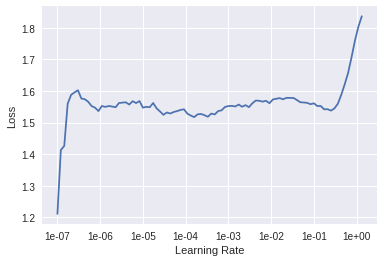

In [295]:
learner.recorder.plot(skip_start=0, skip_end=10)

In [296]:
# I've tried 5e-2 first based on the graph, it diverged
save_model = SaveModelCallback(learner, name='v1')
learner.fit_one_cycle(10, max_lr=5e-3, callbacks=[save_model])

epoch,train_loss,valid_loss
1,1.061232,1.021783
2,0.912022,0.910538
3,0.884220,0.909992
4,0.843703,0.887165
5,0.833965,0.874273
6,0.802136,0.854173
7,0.776842,0.841147
8,0.720357,0.830901
9,0.696311,0.826440
10,0.635720,0.826134


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5e2f08b8d0>>
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f5e2f08b8d0>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
As

(array([   16.,   164.,  1619.,  8369., 15002., 13941.,  6735.,  1236.,   101.,    17.]),
 array([-0.565005, -0.451022, -0.337039, -0.223056, -0.109072,  0.004911,  0.118894,  0.232877,  0.34686 ,  0.460843,
         0.574826]),
 <a list of 10 Patch objects>)

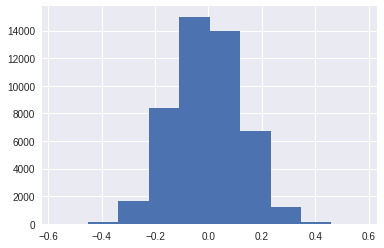

In [313]:
plt.hist(learner.model.u_weight.weight.detach().cpu().numpy().flat)

In [314]:
help(learner.bias)

Help on method bias in module fastai.collab:

bias(arr:Collection, is_item:bool=True) method of fastai.collab.CollabLearner instance
    Bias for item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)



In [318]:
g = ratings_with_title.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

In [325]:
movie_bias = learner.model.i_bias.weight.detach()
movie_bias.shape

torch.Size([1654, 1])

In [345]:
top_movies

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', ...,
       'In the Bleak Midwinter (1995)', 'Party Girl (1995)', 'Highlander III: The Sorcerer (1994)',
       'Bastard Out of Carolina (1996)'], dtype=object)

In [343]:
learner.weight(['Star Wars (1977)']).shape

torch.Size([1, 50])

In [329]:
movie_weights = learner.weight(top_movies, is_item=True)
movie_weights.shape

torch.Size([1000, 50])

In [0]:
from sklearn.decomposition import PCA

In [342]:
pca = PCA(n_components = 3)
pca_components = pca.fit_transform(movie_weights)
pca_components.shape

(1000, 3)